##### Arjun Prakash (21239525)
##### MSc-1MAI
##### Assignment -2 

## Importing and Class implementation

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import pickle as pk

#Implementing sigmoid function
def sig(x):
    return 1/(1+ np.exp(-x))

#implementing NeuralNetwork class
class NeuralNet:
    def __init__(self, x, y):
        self.input    = x                 #Initializing Input layer
        self.y        = y                 # Initializing actual outputs
        # Initializing Weights for input to 1st layer of dimension (n,6) where n is the input dimension
        self.weights_l1   = np.random.rand(self.input.shape[1],6)       
        # Initializing Weights for layer 2 to 3
        self.weights_l2 = np.random.rand(len(self.weights_l1[0]),6)
        # Initializing weights for layer 3-4 with dimension (6,1)
        self.weights_l3 = np.random.rand(len(self.weights_l2[0]),1)
        # Initializing predicted output neuron
        self.output     = np.zeros(y.shape)
        
        # Initializing layers
        self.layer1=0
        self.layer2=0
        self.output=0
        
        # List for storing the decrease in loss with respect to epochs
        self.loss=[]
        
    # Feed forward implementation without using bias variable
    def feed_forward(self):
        self.layer1=sig(np.dot(self.input,self.weights_l1))
        self.layer2=sig(np.dot(self.layer1,self.weights_l2))
        self.output=sig(np.dot(self.layer2,self.weights_l3))
        
    # Backpropagation for training the model and reducing the loss 
    def back_propagate(self):
        #storing loss of each epochs in a list
        self.loss.append(1/len(self.input)*np.log((self.y+1)/(self.output+1))) #Mean Squared Logarithmic Error Loss.
        
        # Updating weights of 3rd to 4th layer and storing it in der_weights
        change_w3=2*(self.y - self.output)*self.output*(1-self.output)   # 
        der_weights_3 = (1/len(self.input))*np.dot(self.layer2.T,change_w3)
        
        # Updating weights of 2nd to 3rd layer and storing it in der_weights
        change_w2=np.dot(change_w3,self.weights_l3.T) * self.layer2*(1-self.layer2)
        der_weights_2 = (1/len(self.input))*np.dot(self.layer1.T,change_w2)
        
        # Updating weights of 1st to 2nd layer and storing it in der_weights        
        change_w1=np.dot(change_w2,self.weights_l2.T)*self.layer1*(1-self.layer1)
        der_weights_1= (1/len(self.input))*np.dot(self.input.T,change_w1)
        
        # Updating all the weights 
        self.weights_l1+=der_weights_1   
        self.weights_l2+=der_weights_2
        self.weights_l3+=der_weights_3
   
    # Function for training the model
    def fit_nn(self,epochs):
        for i in range(epochs):
            self.feed_forward()    
            self.back_propagate()
            
    # Function for predicting the model
    def predict_nn(self,test_input):
        test=sig(np.dot(test_input,self.weights_l1))
        test1=sig(np.dot(test,self.weights_l2))
        testout=sig(np.dot(test1,self.weights_l3))
        return testout
    

    # For returning weights
    def getweights(self):
        return self.weights_l1, self.weights_l2,self.weights_l3
    
    def __str__(self):
        return "Network is of shape:{0},{1},{2},{3}".format(self.input.shape,self.weights_l1[0].shape,self.weights_l2[0].shape,
                                                                self.weights_l3[0].shape)    

### Preprocessing

In [2]:
# Naming all the columns of the data file. Input own column names by changing this variable
col=["fire", "year", "temp", "humidity", "rainfall", "drought_code", "buildup_index", "day", "month", "wind_speed"]

# Reading the data file, change this path depending on the file location
data=pd.read_csv("D:\StudyMaterial - MSc AI\Semister 1\ML\Assignment-2\wildfire.txt",names=col)

# Preprocessing all the texts of output column to 0/1 
data['fire']=data['fire'].replace("no",0)
data['fire']=data['fire'].replace("yes",1)



### Training

In [3]:
# Variable for storing F1 score of the model
own=[]
# List for storing F1 score of sklearn classifier
skf1=[]

# Running the train/test and prediction 10 times
for itr in range(10):
    # splitting train/test data with random shuffles in evry iteration
    X_train, X_test, y_train, y_test = train_test_split(data, data["fire"],test_size=0.33333)
    
    # Dropping fire column 
    X_train=np.array(X_train.drop(labels=["fire"],axis=1))
    y_train=np.array([[i] for i in y_train.tolist()])

    y_test=np.array([[i] for i in y_test.tolist()])
    X_test=np.array(X_test.drop(labels=["fire"],axis=1))
    
    # Standarizing data, this makes mean as 0 and standard deviation as 1. 
    scl_x=StandardScaler()
    normalised_x=scl_x.fit_transform(X_train)
    normalised_y=scl_x.transform(X_test)
            
    # Initializing neuralnetwork object with training data at 1800 epochs
    nn = NeuralNet(normalised_x,y_train)
    # Adjust this value for changing epochs 
    epochs=1800
    nn.fit_nn(epochs)
    
    # List for storing classified data
    predicted=[]
    for i,j in zip(normalised_y,y_test):
        predicted.append(np.round(nn.predict_nn(i)).tolist())
     # List for storing F1 score of the model
    own.append(f1_score(predicted,y_test))
    
     #Exporting predicted files.
    file=pd.DataFrame()
    file['predicted']=predicted
    file['actual']=y_test
    file['predicted']=file['predicted'].apply(lambda x: int(np.array(x)))
    file['Correct_Classification']=file['predicted']==file['actual']
    file.to_csv('Predictions_{}.csv'.format(itr+1),index=False)
    
    
    # Pickling the weights - Uncomment the below line for pickling weights
    #pk.dump(nn,open("model_{}.pkl".format(itr+1), "wb"))
    
    #--------------------------------------------------------------------------------#
    
    # Implementing SKlearn Multi Layer Perceptron model with same number of neurons as above.

    mlp = MLPClassifier(hidden_layer_sizes=(6,6), activation='tanh', max_iter=epochs)
    mlp.fit(normalised_x,np.ravel(y_train))

    predict_train = mlp.predict(normalised_x)
    predict_test = mlp.predict(normalised_y)
    skf1.append(f1_score(predict_test,y_test))
    
    # Printing F1 scores for both the models. 
    print("Itr:",itr+1)
    print("F1 score (Own Model)",":",own[-1])
    print("\nTrain data prediction F1 score (Sklearn):",f1_score(predict_train,y_train))
    print("Test data prediciton F1 score (sklearn):",skf1[-1])
    print()

# Printing data details
print("\nTrained with:", len(normalised_x)*len(y_train)/len(normalised_x)," samples")
print("Tested with :",len(normalised_y)*len(y_test)/len(normalised_y)," samples")
print('Total data size:',len(data))

Itr: 1
F1 score (Own Model) : 0.8974358974358975

Train data prediction F1 score (Sklearn): 0.9923664122137404
Test data prediciton F1 score (sklearn): 0.8205128205128206

Itr: 2
F1 score (Own Model) : 0.8571428571428571

Train data prediction F1 score (Sklearn): 1.0
Test data prediciton F1 score (sklearn): 0.8219178082191781

Itr: 3
F1 score (Own Model) : 0.8571428571428571

Train data prediction F1 score (Sklearn): 0.9864864864864865
Test data prediciton F1 score (sklearn): 0.8378378378378378



C:\Users\arjun\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1800) reached and the optimization hasn't converged yet.
  warnings.warn(


Itr: 4
F1 score (Own Model) : 0.8831168831168831

Train data prediction F1 score (Sklearn): 0.9857142857142858
Test data prediciton F1 score (sklearn): 0.8169014084507042

Itr: 5
F1 score (Own Model) : 0.8823529411764706

Train data prediction F1 score (Sklearn): 1.0
Test data prediciton F1 score (sklearn): 0.9253731343283583

Itr: 6
F1 score (Own Model) : 0.8823529411764706

Train data prediction F1 score (Sklearn): 0.9931972789115647
Test data prediciton F1 score (sklearn): 0.9142857142857143



C:\Users\arjun\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1800) reached and the optimization hasn't converged yet.
  warnings.warn(


Itr: 7
F1 score (Own Model) : 0.875

Train data prediction F1 score (Sklearn): 0.9928057553956835
Test data prediciton F1 score (sklearn): 0.8717948717948718

Itr: 8
F1 score (Own Model) : 0.7999999999999999

Train data prediction F1 score (Sklearn): 1.0
Test data prediciton F1 score (sklearn): 0.8571428571428571

Itr: 9
F1 score (Own Model) : 0.90625

Train data prediction F1 score (Sklearn): 1.0
Test data prediciton F1 score (sklearn): 0.8852459016393444

Itr: 10
F1 score (Own Model) : 0.8307692307692308

Train data prediction F1 score (Sklearn): 1.0
Test data prediciton F1 score (sklearn): 0.7619047619047619


Trained with: 136.0  samples
Tested with : 68.0  samples
Total data size: 204


## Visualization

In [4]:
# Dataframe containing F1 Scores of both the models and the difference in their F1 scores
df=pd.DataFrame()
df['own_model']=own
df['sklearn_model']=skf1
df['difference']=df['own_model']-df['sklearn_model']

#df

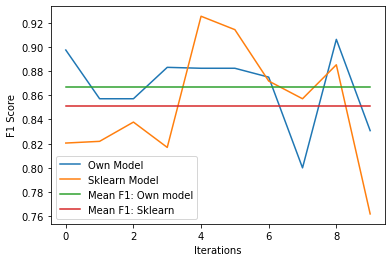

In [5]:
# Plotting the scores for each shuffle (10 times)
plt.xlabel("Iterations")
plt.ylabel("F1 Score")
plt.plot(df['own_model'],label="Own Model")
plt.plot(df['sklearn_model'],label="Sklearn Model")
plt.plot([df['own_model'].mean() for i in range(10)], label='Mean F1: Own model')
plt.plot([df['sklearn_model'].mean() for i in range(10)], label='Mean F1: Sklearn')

plt.legend()


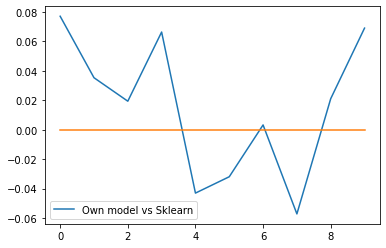

In [6]:

# Plotting the difference. For values <0, Sklearn had better classification accuracy.
plt.plot(df['difference'],label="Own model vs Sklearn")
plt.plot([0 for i in range(10)])
plt.legend()

In [11]:
# calculating loss
loss=np.sum(nn.loss,axis=1)*-1


### Loss/Cost Function

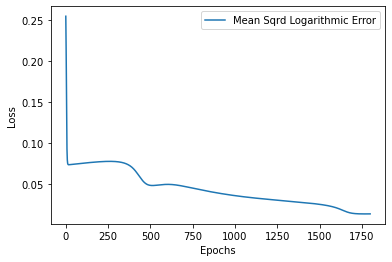

In [12]:

# Plotting loss for each Epoch
plt.plot(loss,label="Mean Sqrd Logarithmic Error")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()